In [ ]:
import os
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, callbacks
import tensorflow.keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

Kaggle Setup

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vighneshvmandavkar","key":"3e65d69233fc10e90eb78497cf58ecfe"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download vighneshvmandavkar/fewshot-data

 30% 5.00M/16.5M [00:00<00:00, 32.0MB/s]
100% 16.5M/16.5M [00:00<00:00, 67.8MB/s]


In [ ]:
! unzip fewshot-data.zip

Archive:  fewshot-data.zip
  inflating: dataset/test/not_jamini/1.jpeg  
  inflating: dataset/test/not_jamini/2.jpeg  
  inflating: dataset/test/not_jamini/3.jpeg  
  inflating: dataset/test/not_jamini/4.jpeg  
  inflating: dataset/test/not_jamini/5.jpeg  
  inflating: dataset/test/not_jamini/Jamini-Roy-Paintings5.jpg  
  inflating: dataset/test/not_jamini/Jamini-Roy-Paintings6.jpg  
  inflating: dataset/test/not_jamini/Prabhakar Kolte.jpeg  
  inflating: dataset/test/not_jamini/amritashergil.jpeg  
  inflating: dataset/test/not_jamini/jamini1.jpeg  
  inflating: dataset/test/painting/2012_CKS_05415_0064_000(jamini_roy_untitled064340)-1893230946.jpg  
  inflating: dataset/test/painting/Jamini-Roy-3464572219.jpg  
  inflating: dataset/test/painting/Jamini-Roy-Paintings12.jpg  
  inflating: dataset/test/painting/Jamini-Roy-Paintings19.jpeg  
  inflating: dataset/test/painting/Jamini-Roy-Paintings2.jpg  
  inflating: dataset/test/painting/Jamini-Roy-Paintings27.jpg  
  inflating: dataset/

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
image_width = 224
image_height = 224
num_classes = 3
histories = []

In [ ]:
images_dir = "/content/dataset/"
train_data_dir = images_dir + "train/"
val_data_dir = images_dir + "val/"
test_data_dir = images_dir + "test/"

In [ ]:
checkpoint_dir = "checkpoints/"
checkpoint_name = checkpoint_dir + "jamini-roy-transferLearning-{val_loss:.4f}-{val_accuracy:.4f}.hdf5"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [ ]:
def create_callbacks():
    return [
        callbacks.EarlyStopping(monitor="val_accuracy", patience=10, verbose=1),

        callbacks.ModelCheckpoint(checkpoint_name, monitor="val_accuracy",
                                  verbose=1, save_best_only=True),
    ]

my_callbacks = create_callbacks()

In [ ]:
my_callbacks = create_callbacks()

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(input_shape=(image_height, image_width, 3),
                       include_top=False, weights="imagenet",
                       pooling=None)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_datagen = ImageDataGenerator(
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    channel_shift_range=0.2,
                    horizontal_flip=True,
                    fill_mode="nearest",
                    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:


batch_size = 3

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=['painting', 'polar_bear', 'not_jamini']
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=['painting', 'polar_bear', 'not_jamini']
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=['painting', 'polar_bear', 'not_jamini']
)

Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 21 images belonging to 3 classes.


In [ ]:
print("Class names:", list(train_generator.class_indices))

Class names: ['painting', 'polar_bear', 'not_jamini']


In [ ]:
from tensorflow.keras import regularizers

top_model = Sequential()
top_model.add(base_model)
top_model.add(GlobalAveragePooling2D())
top_model.add(Dropout(0.7))
top_model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.01)))
top_model.add(Activation("softmax"))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

top_model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(learning_rate=1e-2),
                  metrics=["accuracy"])

In [ ]:
histories.append(top_model.fit(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=60,
                              callbacks=my_callbacks,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              workers=8))

Epoch 1/60
4/5 [=======================>......] - ETA: 0s - loss: 4.9465 - accuracy: 0.1667     
Epoch 1: val_accuracy improved from -inf to 0.73333, saving model to checkpoints/jamini-roy-transferLearning-0.6852-0.7333.hdf5
5/5 [==============================] - 21s 3s/step - loss: 4.0281 - accuracy: 0.2667 - val_loss: 0.6852 - val_accuracy: 0.7333
Epoch 2/60
3/5 [=================>............] - ETA: 0s - loss: 1.7803 - accuracy: 0.3333
Epoch 2: val_accuracy improved from 0.73333 to 0.86667, saving model to checkpoints/jamini-roy-transferLearning-0.4435-0.8667.hdf5
5/5 [==============================] - 7s 1s/step - loss: 1.8590 - accuracy: 0.5333 - val_loss: 0.4435 - val_accuracy: 0.8667
Epoch 3/60
4/5 [=======================>......] - ETA: 0s - loss: 0.1461 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.86667
5/5 [==============================] - 6s 2s/step - loss: 0.1858 - accuracy: 1.0000 - val_loss: 0.6129 - val_accuracy: 0.7333
Epoch 4/60
3/5 [==============

## Evaluate on the best model

In [ ]:
from tensorflow.keras.models import load_model
model_saved_name = ""

best_model = load_model(checkpoint_dir + "jamini-roy-transferLearning-0.2730-0.9333.hdf5")

In [ ]:
best_model.evaluate_generator(test_generator, steps=len(test_generator))

[0.6871960759162903, 0.8571428656578064]

In [ ]:
test_generator.reset()
probabilities = best_model.predict_generator(test_generator, steps=len(test_generator))
predicted_labels = np.argmax(probabilities, axis=-1)

In [ ]:
target_labels = test_generator.classes

In [ ]:
from sklearn import metrics
conf = metrics.confusion_matrix(target_labels, predicted_labels)


In [ ]:
import seaborn as sns

def plot_confusion_matrix(conf, labels, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(conf, annot=True, fmt="d")
    heatmap.xaxis.set_ticklabels(labels, rotation=45, ha="right", fontsize=12)
    heatmap.yaxis.set_ticklabels(labels, rotation=0, ha="right", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.show()

In [ ]:
labels = [""] * num_classes
for k, v in test_generator.class_indices.items():
    labels[v] = k

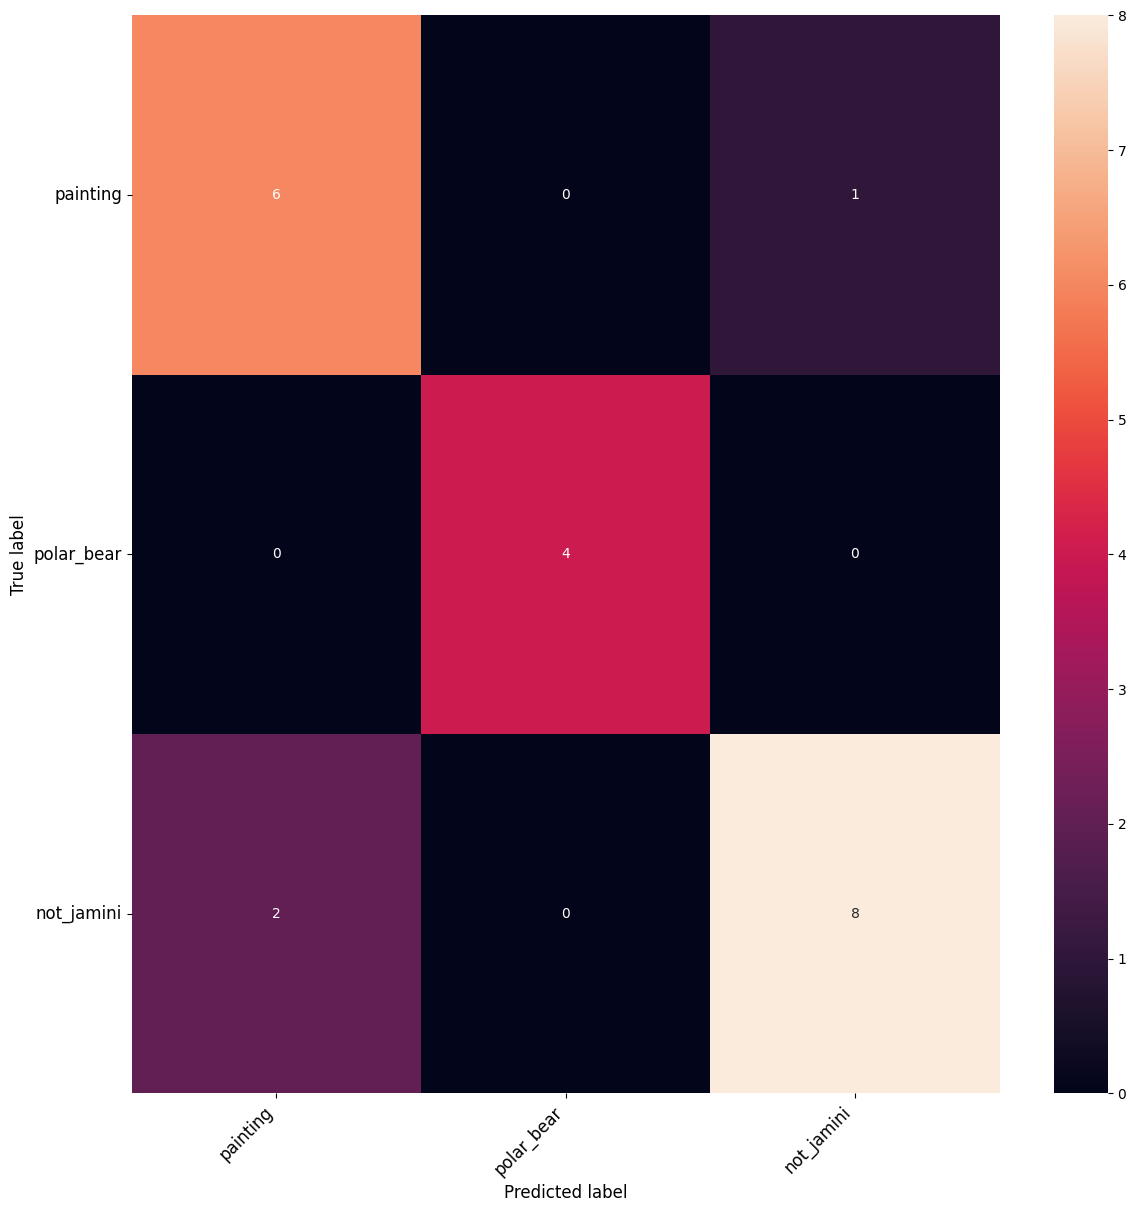

In [ ]:
plot_confusion_matrix(conf, labels, figsize=(14, 14))

In [ ]:
print(metrics.classification_report(target_labels, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

    painting       0.75      0.86      0.80         7
  polar_bear       1.00      1.00      1.00         4
  not_jamini       0.89      0.80      0.84        10

    accuracy                           0.86        21
   macro avg       0.88      0.89      0.88        21
weighted avg       0.86      0.86      0.86        21



In [ ]:
# Find for which images the predicted class is wrong
wrong_images = np.where(predicted_labels != target_labels)[0]

# For every prediction, find the largest probability value;
# this is the probability of the winning class for this image
probs_max = np.max(probabilities, axis=-1)

# Sort the probabilities from the wrong images from low to high
idx = np.argsort(probs_max[wrong_images])

# Reverse the order (high to low), and keep the 5 highest ones
idx = idx[::-1][:5]

# Get the indices of the images with the worst predictions
worst_predictions = wrong_images[idx]

index2class = {v:k for k,v in test_generator.class_indices.items()}

for i in worst_predictions:
    print("%s was predicted as '%s' %.4f\n" % (
        test_generator.filenames[i],
        index2class[predicted_labels[i]],
        probs_max[i]
    ))

not_jamini/jamini1.jpeg was predicted as 'painting' 0.9984

not_jamini/Jamini-Roy-Paintings5.jpg was predicted as 'painting' 0.9498

painting/Jamini-Roy-Paintings27.jpg was predicted as 'not_jamini' 0.7593



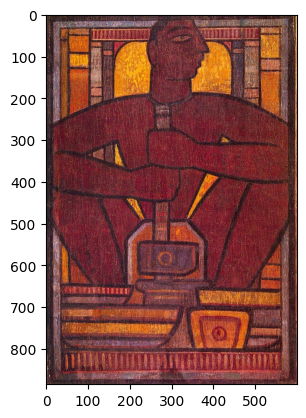

In [ ]:
from keras.preprocessing import image
img = image.load_img(test_data_dir + test_generator.filenames[worst_predictions[2]])
plt.imshow(img)